# Projekt - Text Analytics

In [1]:
import pandas as pd
import os
import numpy as np


from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer # für BoW
from sklearn.feature_extraction.text import TfidfVectorizer # für TF-IDF

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression


from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re

from save_functions import *


c:\Users\ikee9\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\feature_extraction\image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
c:\Users\ikee9\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in 

## Einlesen der Textfiles

Datensatz - Kaggle: https://www.kaggle.com/datasets/shivamkushwaha/bbc-full-text-document-classification/code

Im Ordner BBC gibt es für jede News Kategorie einen Unterordner in welchen die Artikel gespeichert sind.

- business
- entertainment
- politics
- sport
- tech

Die einzelnen Textfiles beinhalten in der ersten Zeile den Titel und darunter den Inhalt. 

Für jedes Textfile wird der Titel des Artikels und den Artikel extrahiert und anschliessend in einem Dataframe abgespeichert. 

In [2]:
path = "./bbc/"
directory = []
file = []
title = []
text = []
label = []
for root, dir, files in os.walk(path):
    try:
        files.remove("README.TXT")
    except:
        pass
    for filename in files:
        directory.append(root)
        file.append(filename)
        label.append(root.split("/")[-1])
        fullpathfile = os.path.join(root,filename)
        with open(fullpathfile,"r", encoding = "utf8", errors = "ignore") as infile:
            intext = ""
            firstline = True
            for line in infile:
                if firstline:
                    title.append(line.replace('\n',''))
                    firstline = False
                else:
                    intext = intext + " " + line.replace('\n','')
            text.append(intext)

bbc_df = pd.DataFrame(list(zip(directory,file,title,text,label)),
                columns = ['directory', 'file', 'title', 'text', 'label'])


In [3]:
bbc_df.head()

directory     file                              title  \
0  ./bbc/business  001.txt  Ad sales boost Time Warner profit   
1  ./bbc/business  002.txt   Dollar gains on Greenspan speech   
2  ./bbc/business  003.txt  Yukos unit buyer faces loan claim   
3  ./bbc/business  004.txt  High fuel prices hit BA's profits   
4  ./bbc/business  005.txt  Pernod takeover talk lifts Domecq   

                                                text     label  
0    Quarterly profits at US media giant TimeWarn...  business  
1    The dollar has hit its highest level against...  business  
2    The owners of embattled Russian oil giant Yu...  business  
3    British Airways has blamed high fuel prices ...  business  
4    Shares in UK drinks and food firm Allied Dom...  business

In [4]:
# Anzahl Dokumenten
bbc_df.shape

(2225, 5)

In [5]:
bbc_df.isnull().sum()

directory    0
file         0
title        0
text         0
label        0
dtype: int64

In [6]:
bbc_df['label'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: label, dtype: int64

## Labels --> Numeric

Hier werden die Labels in numerische Label umgewandelt.

In [7]:
bbc_df['label_num'] = LabelEncoder().fit_transform(bbc_df['label'])
bbc_df.head()

directory     file                              title  \
0  ./bbc/business  001.txt  Ad sales boost Time Warner profit   
1  ./bbc/business  002.txt   Dollar gains on Greenspan speech   
2  ./bbc/business  003.txt  Yukos unit buyer faces loan claim   
3  ./bbc/business  004.txt  High fuel prices hit BA's profits   
4  ./bbc/business  005.txt  Pernod takeover talk lifts Domecq   

                                                text     label  label_num  
0    Quarterly profits at US media giant TimeWarn...  business          0  
1    The dollar has hit its highest level against...  business          0  
2    The owners of embattled Russian oil giant Yu...  business          0  
3    British Airways has blamed high fuel prices ...  business          0  
4    Shares in UK drinks and food firm Allied Dom...  business          0

In [8]:
label_lookup_table = {0: 'business',
                    1: 'entertainment',
                    2: 'politics',
                    3: 'sport',
                    4: 'tech'}

# Text Preprocessing

In diesem Teil werden verschiedene Text preprocessing Schritte auf die einzelnen Dokumenten ausgeführt.

In [9]:
def lowercase(text):
    """
    Alle Wörter im Dokument in lowercase umwandeln
    """
    # Alle Wörter in lowercase umwandeln
    res = text.lower()
    return res

In [10]:
def remove_stopwords(text):
    """
    Die englischen Stoppwörter entfernen
    """
    STOPWORDS = set(stopwords.words('english'))
    res = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return res

In [11]:
def remove_numbers(text):
    """
    Entfernung von Zahlen
    """
    NUMBERS = '[0-9]'
    res = re.sub(NUMBERS, '', str(text))
    return res

In [12]:
def remove_symbols(text):
    """
    Entfernung von speziellen characters
    """
    SPECIAL_CHARACTERS = '[^A-Za-z0-9.]+'
    res = re.sub(SPECIAL_CHARACTERS, ' ', str(text))
    return res

In [13]:
def remove_punct(text):
    """
    Entfernung von Punktuation
    """
    PUNCTUATIONS = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    for ele in text:
        if ele in PUNCTUATIONS:
            text = text.replace(ele, "")
    return text

In [14]:
def porter_stem(text):
    """
    Andwendung von Porterstemmer

    """
    res = ' '.join(PorterStemmer().stem(word) for word in text.split())
    return res

In [15]:
def remove_char(text):

    """

    Entferne Wörter mit länge = 1

    """

    res = ' '.join(word for word in text.split() if len(word)>1)

    return res

In [16]:
# Lemmatize with POS Tag
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [17]:
def lemmatization(text, pos = False):
    """
    Anwendung von Lemmatisierung

    """
    if pos == True:
        lemmatizer = WordNetLemmatizer()
        res = ' '.join(lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in text.split())
    else:
        lemmatizer = WordNetLemmatizer()
        res = ' '.join(lemmatizer.lemmatize(word) for word in text.split())
    return res

In [18]:
def clean_text(text, lower = False, stopwords = False, numbers = False, symbols = False, punct = False, oneletter = False,  porter_stemmer = False, lemmatizer = False):
    """
    Textbereinigung

    Args:
        text (_type_): _description_
        lower (bool, optional): Anwendung von lowercase() Funktion. Defaults to False.
        stopwords (bool, optional): Anwendung von remove_stopwords() Funktion. Defaults to False.
        numbers (bool, optional): Anwendung von remove_numbers() Funktion. Defaults to False.
        symbols (bool, optional): Anwendung von remove_symbols() Funktion. Defaults to False.
        punct (bool, optional): Anwendung von remove_punct() Funktion. Defaults to False.

    Returns:
        str: Bereinigter Text
    """

    #----- Text to lowercase
    if lower == True:
        text = lowercase(text)
    # text = text.lower()

    #----- Entferne die Stoppwörter
    if stopwords == True:
        text = remove_stopwords(text)
    # text = ' '.join(word for word in text.split() if word not in STOPWORDS)

    #----- Entferne Zahlen
    if numbers == True:
        text = remove_numbers(text)
    # text = re.sub(NUMBERS, '', text)

    #----- Entferne Symbole
    if symbols == True:
        text = remove_symbols(text)
    # text = re.sub(SPECIAL_CHARACTERS, ' ', text)

    #----- Entferne Punctuations
    if punct == True:
        text = remove_punct(text)
    # for ele in text:
    #     if ele in PUNCTUATIONS:
    #         text = text.replace(ele, "")

    #----- Entferne 1 Letter words
    if oneletter == True:
        text = remove_char(text)
    #----- Porter Stemmer
    if porter_stemmer == True:
        text = porter_stem(text)

    #----- Lemmatizer
    if lemmatizer == True:
        text = lemmatization(text, True)

        

   
    return text
    

In [19]:
# cleaning_args = (True, True, True, True, True, True, True, False)

In [20]:
#--------------------------------------------
# Anwendung der Textbereinigungs Funktion
#--------------------------------------------
cleaning_args = (True, True, True, True, True, True, True, False)
bbc_df['text_clean'] = bbc_df['text'].apply(clean_text, args = cleaning_args)

# Mit Lemmatisierung
# cleaning_args = (True, True, True, True, True, False, True)
# bbc_df['text_clean'] = bbc_df['text'].apply(clean_text, args = cleaning_args)

In [21]:
#--------------------------------------------
# Beispiel - Bereinigter Text
#--------------------------------------------
bbc_df['text_clean'][0]

'quarterli profit us media giant timewarn jump bn three month decemb year earlier firm one biggest investor googl benefit sale high speed internet connect higher advert sale timewarn said fourth quarter sale rose bn bn profit buoy one off gain offset profit dip warner bro less user aol time warner said friday own search engin googl internet busi aol mix fortun lost subscrib fourth quarter profit lower preced three quarter howev compani said aol underli profit except item rose back stronger internet advertis revenu hope increas subscrib offer onlin servic free timewarn internet custom tri sign aol exist custom high speed broadband timewarn also restat result follow probe us secur exchang commiss sec close conclud time warner fourth quarter profit slightli better analyst expect film divis saw profit slump help box offic flop alexand catwoman sharp contrast year earlier third final film lord ring trilog boost result full year timewarn post profit bn perform revenu grew bn our financi perf

In [22]:
# Save cleaning Schritte in einem Textfile im Ordner Results
base_dir = "./results/"
foldername = "Full_text_cleaning"
save_cleaning_steps(base_dir, foldername, str(cleaning_args))

Neuer Ordner wurde erstellt!


## ADD STATISCHE ANALYSE


## Vor Stemming

In [23]:
cleaning_args = (True, True, True, True, True, True,  False, False)
bbc_df['text_wordcloud'] = bbc_df['text'].apply(clean_text, args = cleaning_args)

In [24]:
def create_wordcloud(label):
    cloudtext = " ".join(bbc_df[bbc_df["label"].isin([label])]["text_wordcloud"])
    wordcloud = WordCloud().generate(cloudtext)
    plt.figure(figsize=(15,6))
    plt.title(label, fontsize=30)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    sns.set(font_scale=2)

In [25]:
def create_wordplot(label):

    cloudtext = " ".join(bbc_df[bbc_df["label"].isin([label])]["text_wordcloud"])
    counter = Counter(cloudtext.split())
    x= np.asarray(counter.most_common(5), dtype= object).T
    print(x)
    f, ax = plt.subplots(figsize=(15, 6))
    sns.set_theme(style="ticks")
    plt.title('Top 5 words in Kategorie ' + label, fontsize = 30)
    sns.barplot(x=x[1],y=x[0], color="#4CB391").set(xlabel='Anzahl', ylabel='Wort')
    sns.set(font_scale=2)

[['said' 'us' 'bn' 'year' 'mr']
 [1680 772 766 703 600]]
[['said' 'film' 'best' 'year' 'music']
 [825 746 614 454 417]]
[['said' 'mr' 'would' 'labour' 'government']
 [2240 1686 1051 737 730]]
[['said' 'year' 'first' 'game' 'england']
 [941 492 483 479 441]]
[['said' 'people' 'also' 'one' 'mr']
 [1567 958 537 531 509]]


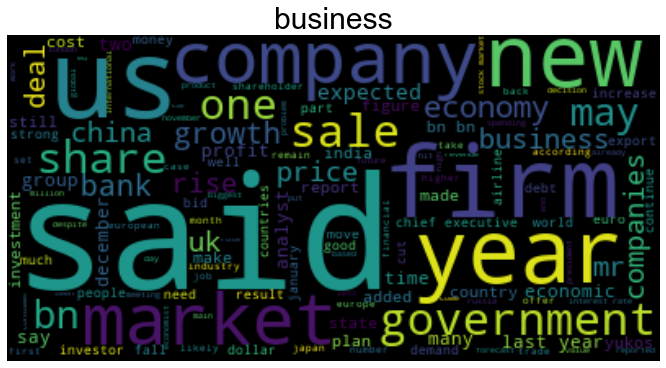

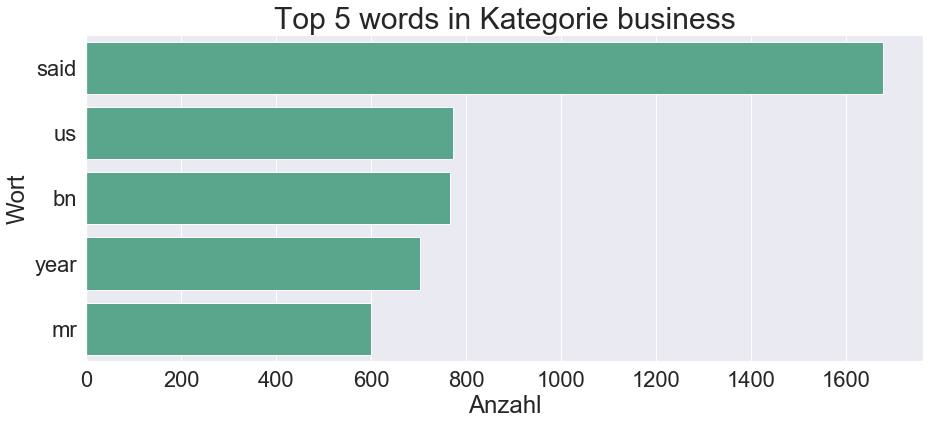

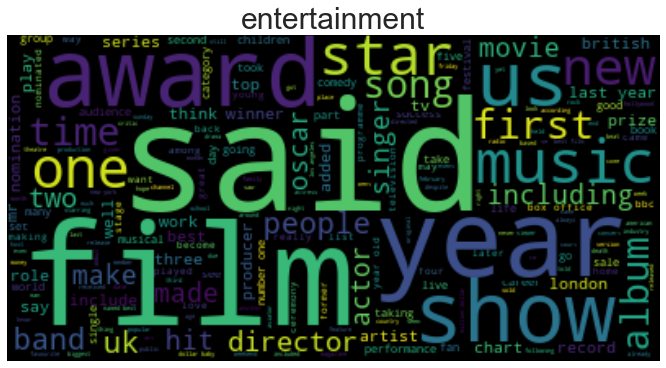

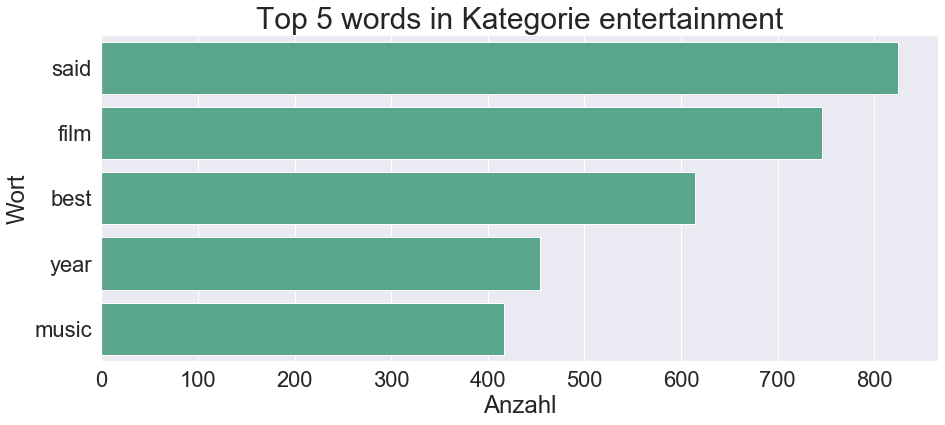

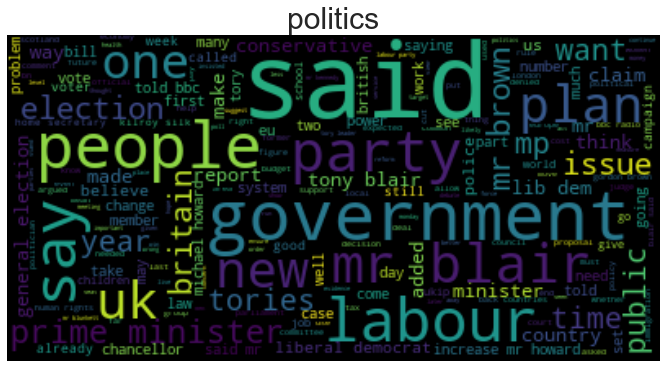

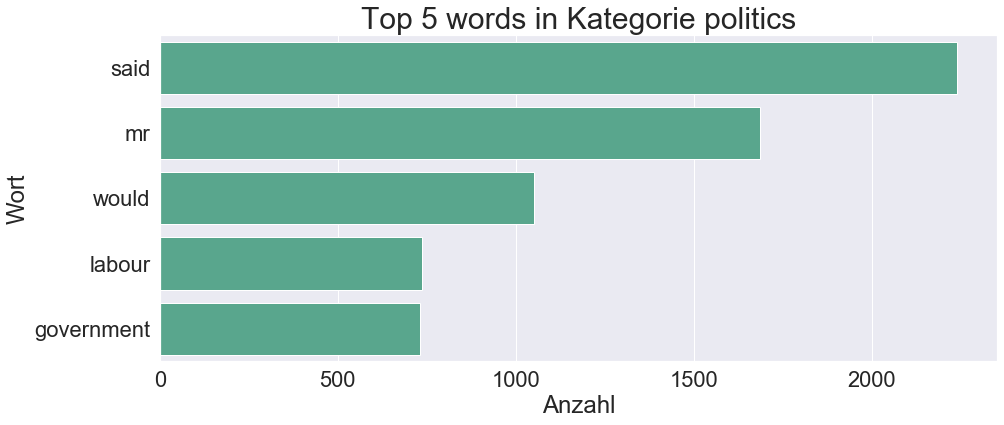

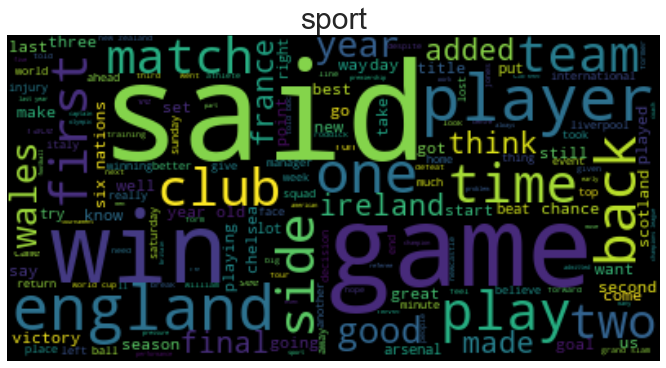

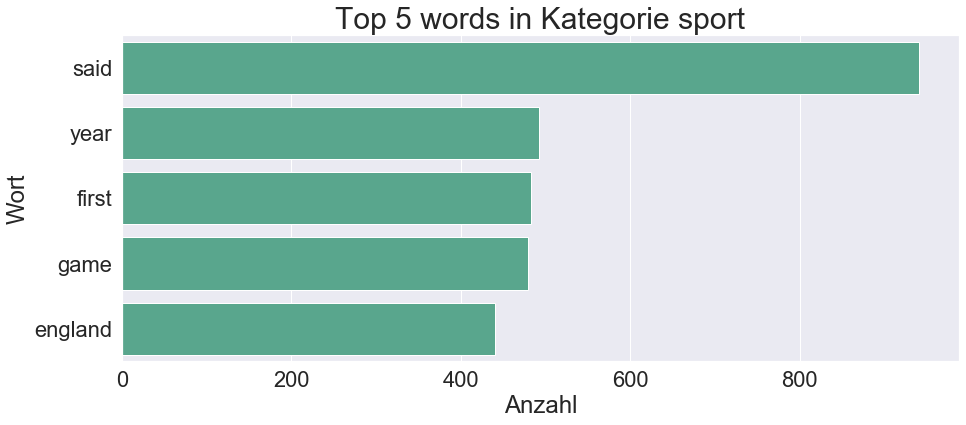

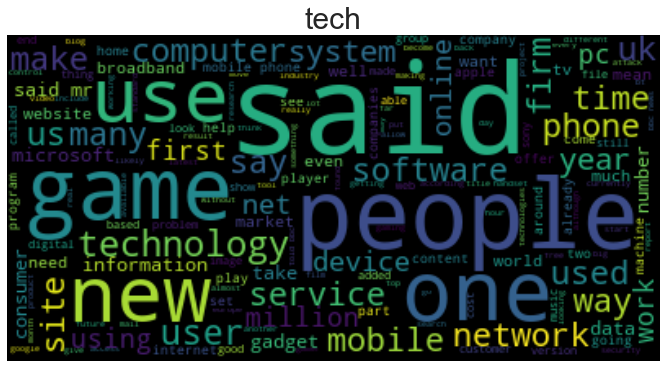

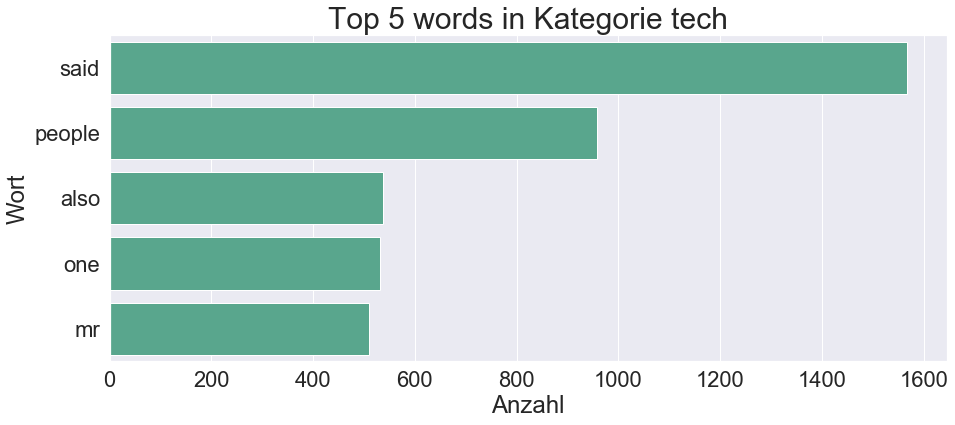

In [26]:
for i in bbc_df["label"].unique():
    create_wordcloud(i)
    create_wordplot(i)    

# Nach Stemming


In [27]:
cleaning_args = (True, True, True, True, True, True, True,  False)
bbc_df['text_wordcloud'] = bbc_df['text'].apply(clean_text, args = cleaning_args)

In [28]:
def create_wordcloud(label):
    cloudtext = " ".join(bbc_df[bbc_df["label"].isin([label])]["text_wordcloud"])
    wordcloud = WordCloud().generate(cloudtext)
    plt.figure(figsize=(15,6))
    plt.title(label, fontsize=30)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    sns.set(font_scale=2)

In [29]:
def create_wordplot(label):

    cloudtext = " ".join(bbc_df[bbc_df["label"].isin([label])]["text_wordcloud"])
    counter = Counter(cloudtext.split())
    x= np.asarray(counter.most_common(5), dtype= object).T
    print(x)
    f, ax = plt.subplots(figsize=(15, 6))
    sns.set_theme(style="ticks")
    plt.title('Top 5 words in Kategorie Nach Stemming ' + label, fontsize = 30)
    sns.barplot(x=x[1],y=x[0], color="#4CB391").set(xlabel='Anzahl', ylabel='Wort')
    sns.set(font_scale=2)

[['said' 'year' 'us' 'bn' 'compani']
 [1680 950 772 766 624]]
[['film' 'said' 'year' 'best' 'music']
 [954 825 678 614 516]]
[['said' 'mr' 'would' 'govern' 'labour']
 [2240 1717 1051 761 737]]
[['said' 'year' 'game' 'play' 'win']
 [941 669 652 624 584]]
[['said' 'use' 'peopl' 'game' 'technolog']
 [1567 1011 958 866 626]]


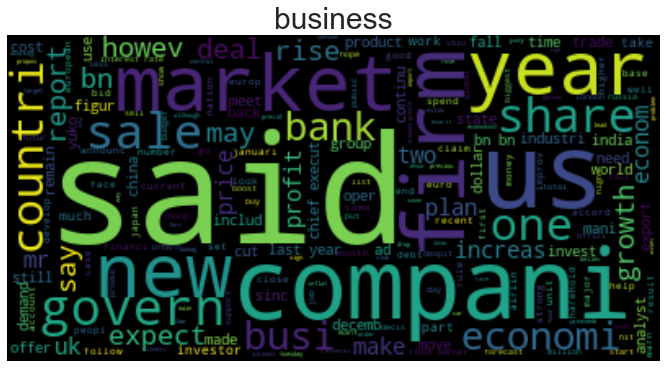

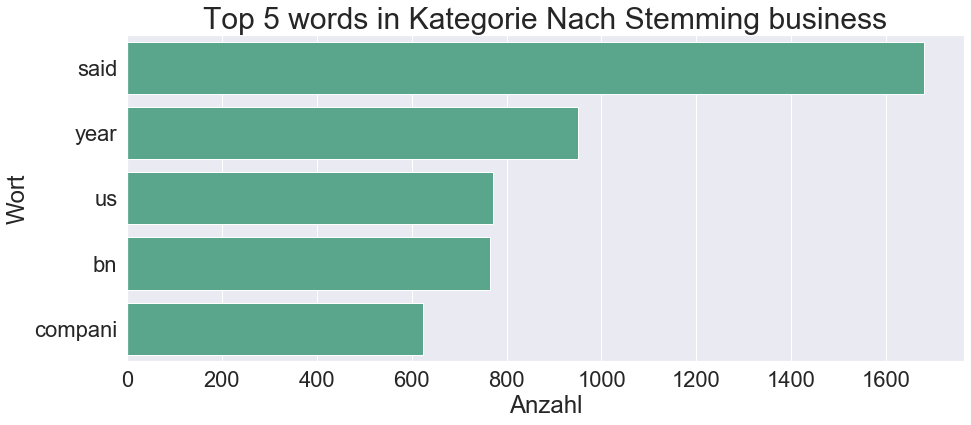

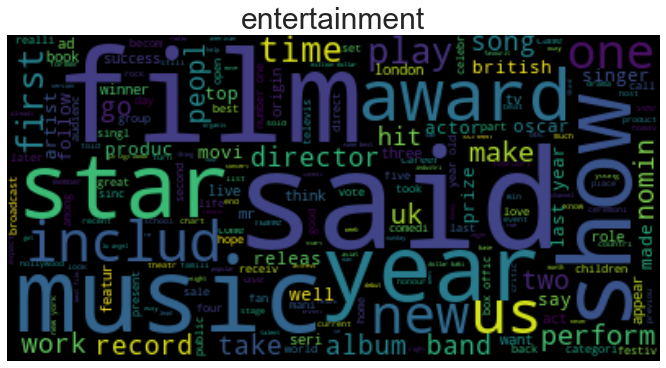

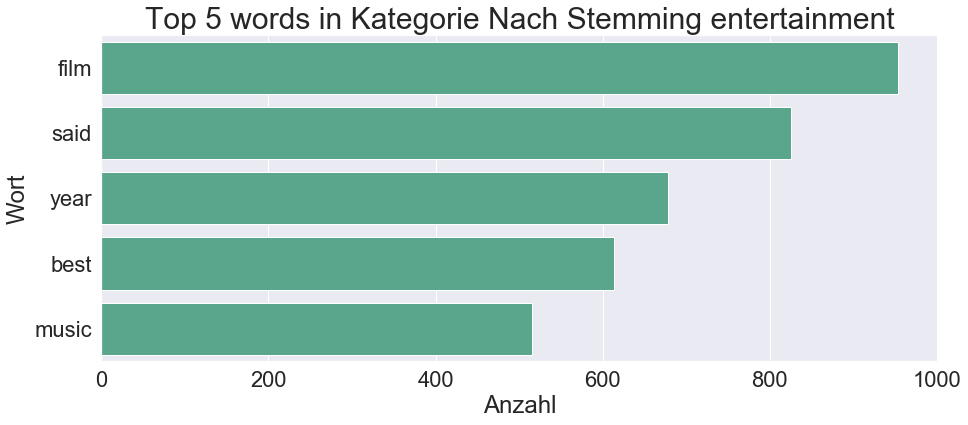

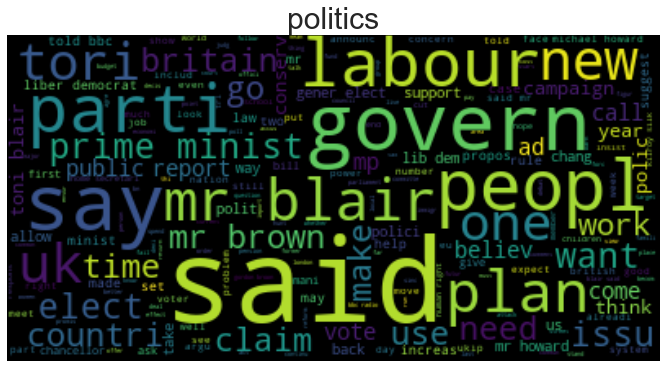

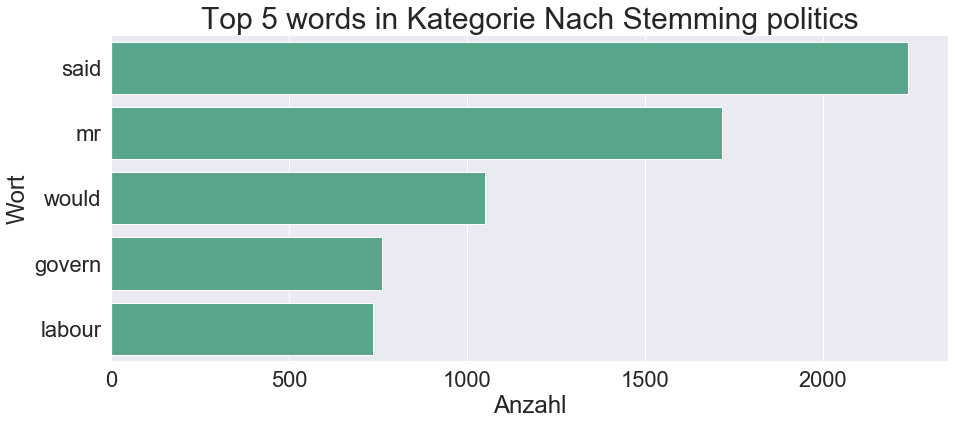

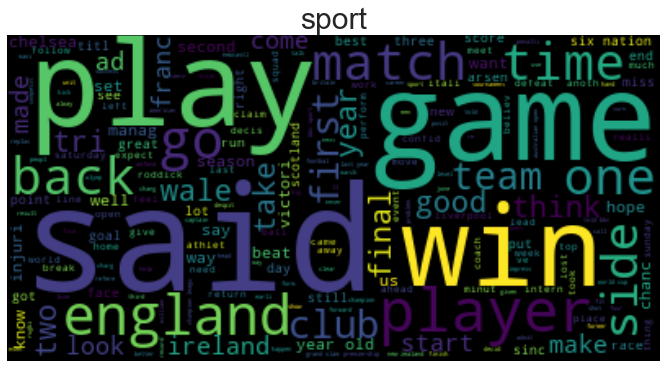

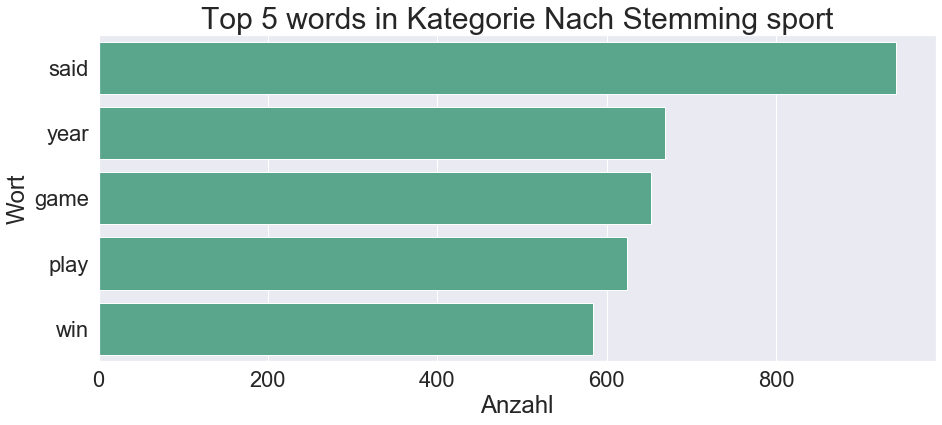

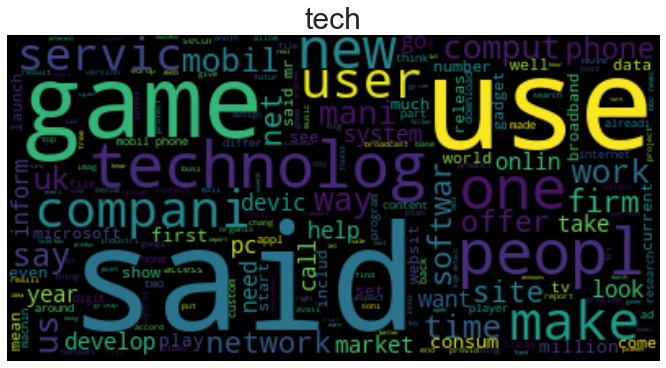

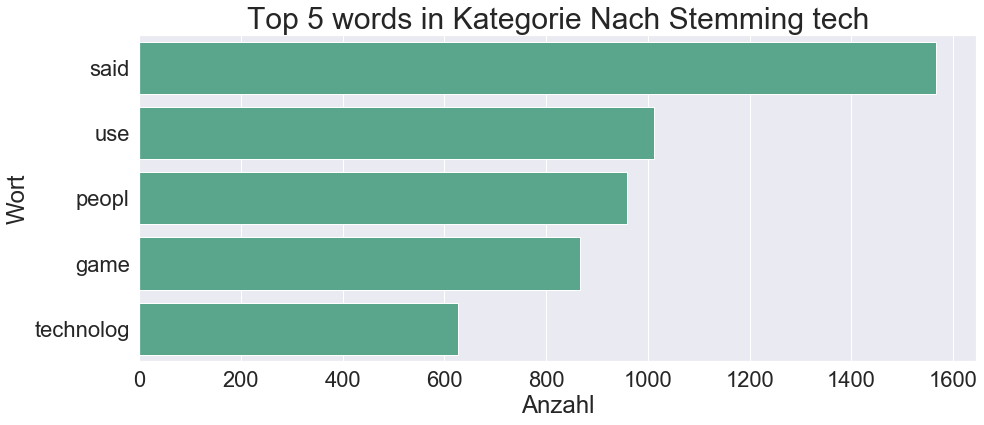

In [30]:
for i in bbc_df["label"].unique():
    create_wordcloud(i)
    create_wordplot(i)    

## Train- & Test-Split

Die Daten in Trainings- und Testdaten aufteilen. 

80% Trainingsdaten und 20% Testdaten

In [31]:
X_train, X_test, y_train, y_test = train_test_split(bbc_df['text_clean'], bbc_df['label_num'], random_state = 0, test_size=0.2)

# Variante 1: CountVectorizer

In [32]:
def cnt_vectorizer(default = True):
    #--------------------------------------------
    # Mit Default einstellungen
    #--------------------------------------------
    if default == True:
        count_vectorizer = CountVectorizer()
        save_count_vectorizer_parameters(base_dir, foldername, 'default Einstellungen')
    else:
        #--------------------------------------------
        # mit definierten Parameter
        #--------------------------------------------
        ngram_range = (1,1)
        max_features = 1500
        min_df = 5 # Minimum number of documents that should contain this feature
        max_df = 0.7 # Only the words which occur in a maximum of max_df percentage of all the documents. 
        count_vectorizer = CountVectorizer(ngram_range=ngram_range,max_features=max_features, min_df=min_df, max_df=max_df)
        save_count_vectorizer_parameters(base_dir, foldername, ('ngram_range: '+str(ngram_range)+' max_features: '+str(max_features)+' min_df: '+str(min_df)+' max_df: '+str(max_df)))
    return count_vectorizer


In [33]:
count_vectorizer = cnt_vectorizer(default = True)

In [34]:
# # --------------------------------------------
# # Anzahl Features - X_train
# # --------------------------------------------
# X_train_bow = count_vectorizer.fit_transform(X_train)
# len(count_vectorizer.get_feature_names())

## Cross-Validation mit CountVectorizer

In diesem Abschnitt werden verschiedene Algorithmen ausprobiert und mit Hilfe von Hyperparameter Tuning werden die Parameter optimiert. Mit Cross-Validation wird die performance des Schätzern evaluiert.

In [35]:
models = [RandomForestClassifier(),
         MultinomialNB(),
         LinearSVC(),
         LogisticRegression()]

param_grid = [[{'model__n_estimators': [100,200,300]}],
            [{'model__alpha': [1.0,2.0,2.5]}],
            [{'model__C': [0.5,1.0,2.0], 'model__max_iter': [10000]}],
            [{'model__C': [1.0,2.0,2.5], 'model__max_iter': [200]}]]

CV = 5

cv_df = pd.DataFrame(index=range(CV * len(models)))

vectorizer = count_vectorizer

entries = []
i = 0
for model in models:
    print(model)
    model_name = model.__class__.__name__
    model_pipe = Pipeline([('vectorizer', vectorizer), ('model', model)])
    clf = GridSearchCV(model_pipe, param_grid[i], scoring='accuracy', cv=CV)
    clf.fit(X_train, y_train)
    best_index = np.where(clf.cv_results_['mean_test_score'] == max(clf.cv_results_['mean_test_score']))
    best_param = list(clf.best_params_.keys())
    for key in best_param:
        new_key = key.split("model__",1)[1]
        clf.best_params_[new_key] = clf.best_params_.pop(key)
    for fold_idx in range(0,CV):
        tag = 'split'+str(fold_idx)+'_test_score'
        entries.append((model_name, fold_idx+1, clf.cv_results_[tag][best_index][0], clf.best_params_))
    i += 1
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy', 'best params']) 

save_count_vectorizer_CV_results(base_dir, foldername, str(models), str(param_grid), cv_df.to_string())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


c:\Users\ikee9\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
c:\Users\ikee9\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or 

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


c:\Users\ikee9\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)
c:\Users\ikee9\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.htm

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)


c:\Users\ikee9\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
c:\Users\ikee9\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


c:\Users\ikee9\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
c:\Users\ikee9\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or 

In [36]:
cv_df

model_name  fold_idx  accuracy                    best params
0   RandomForestClassifier         1  0.952514          {'n_estimators': 200}
1   RandomForestClassifier         2  0.971989          {'n_estimators': 200}
2   RandomForestClassifier         3  0.971910          {'n_estimators': 200}
3   RandomForestClassifier         4  0.966197          {'n_estimators': 200}
4   RandomForestClassifier         5  0.974576          {'n_estimators': 200}
5            MultinomialNB         1  0.980447                 {'alpha': 1.0}
6            MultinomialNB         2  0.969188                 {'alpha': 1.0}
7            MultinomialNB         3  0.977528                 {'alpha': 1.0}
8            MultinomialNB         4  0.966197                 {'alpha': 1.0}
9            MultinomialNB         5  0.980226                 {'alpha': 1.0}
10               LinearSVC         1  0.952514  {'C': 0.5, 'max_iter': 10000}
11               LinearSVC         2  0.983193  {'C': 0.5, 'max_iter': 10000}
12               LinearSVC         3  0.966292  {'C': 0.5, 'max_iter': 10000}
13               LinearSVC         4  0.963380  {'C': 0.5, 'max_iter': 10000}
14               LinearSVC         5  0.977401  {'C': 0.5, 'max_iter': 10000}
15      LogisticRegression         1  0.960894    {'C': 1.0, 'max_iter': 200}
16      LogisticRegression         2  0.983193    {'C': 1.0, 'max_iter': 200}
17      LogisticRegression         3  0.977528    {'C': 1.0, 'max_iter': 200}
18      LogisticRegression         4  0.966197    {'C': 1.0, 'max_iter': 200}
19      LogisticRegression         5  0.980226    {'C': 1.0, 'max_iter': 200}

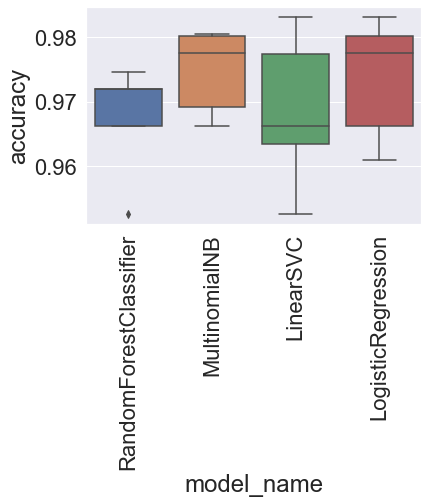

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
g = sns.boxplot(x='model_name', y='accuracy', data=cv_df)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
None
plt.savefig(base_dir+foldername+"/model_cv_boxplot.png", facecolor = 'white', transparent=False, bbox_inches='tight')

In [38]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.968556
LogisticRegression        0.973608
MultinomialNB             0.974717
RandomForestClassifier    0.967437
Name: accuracy, dtype: float64

## Vorhersage - Testset

Hier wird mit dem besten Model einer vorhersage auf den Testdaten gemacht. 

In [39]:
def test_prediction(cv_df, X_train, y_train, y_test, vectorizer, filename):
    model_name = cv_df.model_name.unique()
    for model in model_name:
        if model == 'LinearSVC':
            estimator = LinearSVC(C = cv_df[cv_df['model_name'] == 'LinearSVC'].reset_index()['best params'][0].get('C'), max_iter = cv_df[cv_df['model_name'] == 'LinearSVC'].reset_index()['best params'][0].get('max_iter'))
            model_pipeline = make_pipeline(vectorizer, estimator)
            model_pipeline.fit(X_train, y_train)
            y_pred = model_pipeline.predict(X_test)
            conf_matrix = confusion_matrix(y_test,y_pred)
            report = classification_report(y_test,y_pred)
            save_test_prediction(base_dir, foldername, filename, str(model), str(conf_matrix), str(report))
            save_test_pred_labels(y_test, y_pred, base_dir, foldername,'/LinearSVC_pred_labels')
            if vectorizer == count_vectorizer:
                save_wrong_predictions(y_test, y_pred, base_dir, foldername, '/LinearSVC_wrong_pred')
            else:
                save_wrong_predictions(y_test, y_pred, base_dir, foldername, '/LinearSVC_wrong_pred_TFIDF')
        elif model == 'LogisticRegression':
            estimator = LogisticRegression(C = cv_df[cv_df['model_name'] == 'LogisticRegression'].reset_index()['best params'][0].get('C'), max_iter = cv_df[cv_df['model_name'] == 'LogisticRegression'].reset_index()['best params'][0].get('max_iter'))
            model_pipeline = make_pipeline(vectorizer, estimator)
            model_pipeline.fit(X_train, y_train)
            y_pred = model_pipeline.predict(X_test)
            conf_matrix = confusion_matrix(y_test,y_pred)
            report = classification_report(y_test,y_pred)
            save_test_prediction(base_dir, foldername, filename, str(model), str(conf_matrix), str(report))
            save_test_pred_labels(y_test, y_pred, base_dir, foldername,'/LogisicRegression_pred_labels')
            if vectorizer == count_vectorizer:
                save_wrong_predictions(y_test, y_pred, base_dir, foldername, '/LogisicRegression_wrong_pred')
            else:
                save_wrong_predictions(y_test, y_pred, base_dir, foldername, '/LogisicRegression_wrong_pred_TFIDF')
        elif model == 'MultinomialNB':
            estimator = MultinomialNB(alpha = cv_df[cv_df['model_name'] == 'MultinomialNB'].reset_index()['best params'][0].get('alpha'))
            model_pipeline = make_pipeline(vectorizer, estimator)
            model_pipeline.fit(X_train, y_train)
            y_pred = model_pipeline.predict(X_test)
            conf_matrix = confusion_matrix(y_test,y_pred)
            report = classification_report(y_test,y_pred)
            save_test_prediction(base_dir, foldername, filename, str(model), str(conf_matrix), str(report))
            save_test_pred_labels(y_test, y_pred, base_dir, foldername,'/MultinomialNB_pred_labels')
            if vectorizer == count_vectorizer:
                save_wrong_predictions(y_test, y_pred, base_dir, foldername, '/MultinomialNB_wrong_pred')
            else:
                save_wrong_predictions(y_test, y_pred, base_dir, foldername, '/MultinomialNB_wrong_pred_TFIDF')
        elif model == 'RandomForestClassifier':
            estimator = RandomForestClassifier(n_estimators=cv_df[cv_df['model_name'] == 'RandomForestClassifier'].reset_index()['best params'][0].get('n_estimators'))
            model_pipeline = make_pipeline(vectorizer, estimator)
            model_pipeline.fit(X_train, y_train)
            y_pred = model_pipeline.predict(X_test)
            conf_matrix = confusion_matrix(y_test,y_pred)
            report = classification_report(y_test,y_pred)
            save_test_prediction(base_dir, foldername, filename, str(model), str(conf_matrix), str(report))
            save_test_pred_labels(y_test, y_pred, base_dir, foldername,'/RandomForest_pred_labels')
            if vectorizer == count_vectorizer:
                save_wrong_predictions(y_test, y_pred, base_dir, foldername, '/RandomForest_wrong_pred')
            else:
                save_wrong_predictions(y_test, y_pred, base_dir, foldername, '/RandomForest_wrong_pred_TFIDF')

In [40]:
test_prediction(cv_df, X_train, y_train, y_test, count_vectorizer, filename = '/test_prediction_count_vectorizer')

c:\Users\ikee9\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\ensemble\forest.py:489: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
c:\Users\ikee9\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\tree\tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32`

### Vorhersage mit VotingClassifier

In [41]:
def test_prediction_voting_classifier(cv_df, X_train, y_train, y_test, vectorizer, filename):
    from sklearn.calibration import CalibratedClassifierCV
    model_name = cv_df.model_name.unique()
    estimators = []
    for model in model_name:
        if model == 'LinearSVC':
            estimator = LinearSVC(C = cv_df[cv_df['model_name'] == 'LinearSVC'].reset_index()['best params'][0].get('C'), max_iter = cv_df[cv_df['model_name'] == 'LinearSVC'].reset_index()['best params'][0].get('max_iter'))
            estimators.append(("p1", make_pipeline(vectorizer, CalibratedClassifierCV(estimator))))
        elif model == 'LogisticRegression':
            estimator = LogisticRegression(C = cv_df[cv_df['model_name'] == 'LogisticRegression'].reset_index()['best params'][0].get('C'), max_iter = cv_df[cv_df['model_name'] == 'LogisticRegression'].reset_index()['best params'][0].get('max_iter'))
            estimators.append(("p2", make_pipeline(vectorizer, estimator)))
        elif model == 'MultinomialNB':
            estimator = MultinomialNB(alpha = cv_df[cv_df['model_name'] == 'MultinomialNB'].reset_index()['best params'][0].get('alpha'))
            estimators.append(("p3", make_pipeline(vectorizer, estimator)))
        elif model == 'RandomForestClassifier':
            estimator = RandomForestClassifier(n_estimators=cv_df[cv_df['model_name'] == 'RandomForestClassifier'].reset_index()['best params'][0].get('n_estimators'))
            estimators.append(("p4", make_pipeline(vectorizer, estimator)))
    p5 = make_pipeline(VotingClassifier(estimators=estimators, voting='soft'))
    p5.fit(X_train, y_train)
    y_pred = p5.predict(X_test)
    conf_matrix = confusion_matrix(y_test,y_pred)
    report = classification_report(y_test,y_pred)
    save_test_prediction(base_dir, foldername, filename, 'Voting Classifier', str(conf_matrix), str(report))
    save_test_pred_labels(y_test, y_pred, base_dir, foldername,'/VotingClassifier_pred_labels')
    if vectorizer == count_vectorizer:
        save_wrong_predictions(y_test, y_pred, base_dir, foldername, '/VotingClassifier_wrong_pred')
    else:
        save_wrong_predictions(y_test, y_pred, base_dir, foldername, '/VotingClassifier_wrong_pred_TFIDF')


In [42]:
test_prediction_voting_classifier(cv_df, X_train, y_train, y_test, count_vectorizer, filename = '/test_prediction_count_vectorizer_voting_classifier')

c:\Users\ikee9\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\ensemble\forest.py:489: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
c:\Users\ikee9\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\tree\tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32`

# Variante 2: TF-IDF

funktion einstellungen ausprobieren, ngrams, usw...

In [43]:
def tfidf_vectorizer(default = True):
    #--------------------------------------------
    # Mit Default einstellungen
    #--------------------------------------------
    if default == True:
        tfidf_vectorizer = TfidfVectorizer()
        save_tfidf_vectorizer_parameters(base_dir, foldername, 'default Einstellungen')
    else:
        #--------------------------------------------
        # mit definierten Parameter
        #--------------------------------------------
        ngram_range = (1,1)
        max_features = 1500
        min_df = 5 # Minimum number of documents that should contain this feature
        max_df = 0.7 # Only the words which occur in a maximum of max_df percentage of all the documents. 
        tfidf_vectorizer = TfidfVectorizer(ngram_range=ngram_range,max_features=max_features, min_df=min_df, max_df=max_df)
        save_tfidf_vectorizer_parameters(base_dir, foldername, ('ngram_range: '+str(ngram_range)+' max_features: '+str(max_features)+' min_df: '+str(min_df)+' max_df: '+str(max_df)))
    return tfidf_vectorizer


In [44]:
TFIDF_vectorizer = tfidf_vectorizer(default = False)

## Cross-Validation mit TF-IDf

In [45]:
models = [RandomForestClassifier(),
         MultinomialNB(),
         LinearSVC(),
         LogisticRegression()]

param_grid = [[{'model__n_estimators': [100,200,300]}],
            [{'model__alpha': [1.0,2.0,2.5]}],
            [{'model__C': [0.5,1.0,2.0], 'model__max_iter': [10000]}],
            [{'model__C': [1.0,2.0,2.5], 'model__max_iter': [200]}]]

CV = 5

cv_df = pd.DataFrame(index=range(CV * len(models)))

vectorizer = TFIDF_vectorizer

entries = []
i = 0
for model in models:
    print(model)
    model_name = model.__class__.__name__
    model_pipe = Pipeline([('vectorizer', vectorizer), ('model', model)])
    clf = GridSearchCV(model_pipe, param_grid[i], scoring='accuracy', cv=CV)
    clf.fit(X_train, y_train)
    best_index = np.where(clf.cv_results_['mean_test_score'] == max(clf.cv_results_['mean_test_score']))
    best_param = list(clf.best_params_.keys())
    for key in best_param:
        new_key = key.split("model__",1)[1]
        clf.best_params_[new_key] = clf.best_params_.pop(key)
    for fold_idx in range(0,CV):
        tag = 'split'+str(fold_idx)+'_test_score'
        entries.append((model_name, fold_idx+1, clf.cv_results_[tag][best_index][0], clf.best_params_))
    i += 1
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy', 'best params']) 

save_tfidf_vectorizer_CV_results(base_dir, foldername, str(models), str(param_grid), cv_df.to_string())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


c:\Users\ikee9\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
c:\Users\ikee9\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or 

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


c:\Users\ikee9\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_search.py:794: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)


c:\Users\ikee9\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
c:\Users\ikee9\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


c:\Users\ikee9\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
c:\Users\ikee9\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or 

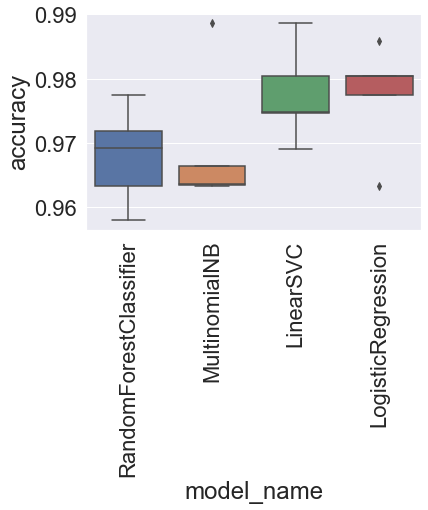

In [46]:
import seaborn as sns
g = sns.boxplot(x='model_name', y='accuracy', data=cv_df)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
None
plt.savefig(base_dir+foldername+"/model_tfidf_cv_boxplot.png", facecolor = 'white', transparent=False, bbox_inches='tight')

In [47]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.977537
LogisticRegression        0.977525
MultinomialNB             0.969126
RandomForestClassifier    0.967990
Name: accuracy, dtype: float64

## Vorhersage - Testset

In [48]:
test_prediction(cv_df, X_train, y_train, y_test, TFIDF_vectorizer, filename = '/test_prediction_tfidf_vectorizer')

c:\Users\ikee9\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\ensemble\forest.py:489: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
c:\Users\ikee9\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\tree\tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32`

### Vorhersage mit VotingClassifier

In [49]:
test_prediction_voting_classifier(cv_df, X_train, y_train, y_test, TFIDF_vectorizer, filename = '/test_prediction_tfidf_vectorizer_voting_classifier')

c:\Users\ikee9\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\ensemble\forest.py:489: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
c:\Users\ikee9\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\tree\tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32`

# Falsch Vorhersagen

In diesem Abschnitt wird untersucht welche Artikel in allen Schätzer falsch vorhergesagt wird.

In [50]:
def comparelists(a,b,c,d):
    z = [x for x in b
         if x in a and x in c and x in d] #list comprehension
    return z

In [51]:
list1 = pd.read_pickle(base_dir + foldername + "/LinearSVC_wrong_pred.pickle") 
list2 = pd.read_pickle(base_dir + foldername + "/RandomForest_wrong_pred.pickle") 
list3 = pd.read_pickle(base_dir + foldername + "/LogisicRegression_wrong_pred.pickle") 
list4 = pd.read_pickle(base_dir + foldername + "/MultinomialNB_wrong_pred.pickle") 
wrong_pred_list = comparelists(list1,list2,list3, list4)
wrong_pred_list

[503, 971, 722, 1436, 486]

In [52]:
bbc_df.iloc[[wrong_pred_list[0]]]

directory     file                              title  \
503  ./bbc/business  504.txt  Aids and climate top Davos agenda   

                                                  text     label  label_num  \
503    Climate change and the fight against Aids ar...  business          0   

                                            text_clean  \
503  climat chang fight aid lead list concern first...   

                                        text_wordcloud  
503  climat chang fight aid lead list concern first...

In [53]:
bbc_df.iloc[[wrong_pred_list[0]]]['text'][wrong_pred_list[0]]

'  Climate change and the fight against Aids are leading the list of concerns for the first day of the World Economic Forum in the Swiss resort of Davos.  Some 2,000 business and political leaders from around the globe will listen to UK Prime Minister Tony Blair\'s opening speech on Wednesday. Mr Blair will focus on Africa\'s development plans and global warming. Earlier in the day came an update on efforts to have 3 million people on anti-Aids drugs by the end of 2005. The World Health Organisation (WHO) said 700,000 people in poor countries were on life-extending drugs - up from 440,000 six months earlier but amounting to only 12% of the 5.8 million who needed them. A $2bn "funding gap" still stood in the way of hitting the 2005 target, the WHO said.  The themes to be stressed by Mr Blair - whose attendance was announced at the last minute - are those he wants to dominate the UK\'s chairmanship of the G8 group of industrialised states. Other issues to be discussed at the five-day con

In [54]:
bbc_df.iloc[[wrong_pred_list[0]]]['text_clean'][wrong_pred_list[0]]

'climat chang fight aid lead list concern first day world econom forum swiss resort davo busi polit leader around globe listen uk prime minist toni blair open speech wednesday mr blair focu africa develop plan global warm earlier day came updat effort million peopl anti aid drug end world health organis who said peopl poor countri life extend drug six month earlier amount million need them bn fund gap still stood way hit target said theme stress mr blair whose attend announc last minut want domin uk chairmanship group industrialis state issu discuss five day confer rang china econom power iraq futur sunday elect asid mr blair world leader expect attend includ french presid jacqu chirac due speak video link bad weather delay helicopt south african presid thabo mbeki whose arriv delay ivori coast peac talk ukrain new presid viktor yushchenko also newli elect palestinian leader mahmoud abba showbiz figur also put appear frontman bono well known campaign trade develop issu angelina joli go

In [55]:
def predicted_labels(index):
    list1 = pd.read_pickle(base_dir + foldername + "/LinearSVC_pred_labels.pickle") 
    list2 = pd.read_pickle(base_dir + foldername + "/RandomForest_pred_labels.pickle") 
    list3 = pd.read_pickle(base_dir + foldername + "/LogisicRegression_pred_labels.pickle") 
    list4 = pd.read_pickle(base_dir + foldername + "/MultinomialNB_pred_labels.pickle") 
    print('True Value: ' + bbc_df.iloc[[wrong_pred_list[0]]]['label'])
    return [('LinearSVC','Preditcted: ' + label_lookup_table[list1.loc[[index]][0][index]]), ('RandomForest','Preditcted: ' +  label_lookup_table[list2.loc[[index]][0][index]]), ('LogisticRegression','Preditcted: ' +  label_lookup_table[list3.loc[[index]][0][index]]), ('MultinomialNB','Preditcted: ' +  label_lookup_table[list4.loc[[index]][0][index]])]

In [56]:
predicted_labels(index = wrong_pred_list[0])

503    True Value: business
Name: label, dtype: object


[('LinearSVC', 'Preditcted: politics'),
 ('RandomForest', 'Preditcted: politics'),
 ('LogisticRegression', 'Preditcted: politics'),
 ('MultinomialNB', 'Preditcted: politics')]

# Word2Vec

## Lade vordefinierten Word Embeddings

In [57]:
# Try a simple Feed-Forward layer over averaged pre-trained word embeddings
import numpy as np

import json
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder

c:\Users\ikee9\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\ikee9\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\ikee9\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\ikee9\AppD

In [58]:
# Hier werden die Originale Dokumenten verwendet
X_train_bbc, X_test_bbc, y_train_bbc, y_test_bbc = train_test_split(bbc_df['text'], bbc_df['label'], random_state = 0)

In [59]:
np.random.seed(42)
tf.random.set_seed(42)

# Download the embeddings and vocab file here: https://drive.switch.ch/index.php/s/rNmy0yKDDkRAmcq
word_embeddings = np.load('wiki.multi.en.vec_data.npy')
vocab = json.load(open('wiki.multi.en.vec_vocab.json'))

def tokenize(texts):
    return [re.findall(r'\w+', text.lower()) for text in texts]

train_tokens = tokenize(X_train_bbc.tolist())
ohe = OneHotEncoder(sparse=False)  # One-hot encode string labels
train_labels = ohe.fit_transform([[label] for label in y_train_bbc.tolist()])

AttributeError: module 'tensorflow._api.v1.random' has no attribute 'set_seed'

In [ ]:
# print(train_labels)

In [ ]:
# Only use needed word embeddings, do this to save RAM
# Build vocab on training data
train_vocab = {'PAD': 0}  # special padding symbol
selected_word_embeddings = [np.zeros(word_embeddings.shape[1])]  # zero vector for PAD symbol
for tokens in train_tokens:
    for token in tokens:
        if not token in train_vocab:
            if token in vocab:
                train_vocab[token] = max(train_vocab.values()) + 1
                selected_word_embeddings.append(word_embeddings[vocab[token]])

selected_word_embeddings = np.array(selected_word_embeddings)
del word_embeddings

In [ ]:
def tok2int(tokens_list, vocab):
    """Replaces tokens with their assigned IDs"""
    token_ints = list()
    for tokens in tokens_list:
        token_ints.append([vocab[tok] for tok in tokens if tok in vocab])
    return token_ints

In [ ]:
maxlen = max(len(tokens) for tokens in train_tokens)
train_ints = tok2int(train_tokens, train_vocab)
# Make all texts the same length, pad with zeroes
# train_ints_padded = tf.keras.utils.pad_sequences(train_ints, maxlen=maxlen)
train_ints_padded = tf.keras.preprocessing.sequence.pad_sequences(train_ints, maxlen=maxlen)

## Neuronales Netz mit vortrainierten word embeddings

In [ ]:
# Define the model: Try changing the layers and their sizes
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(train_vocab), # Number of tokens in the dicitonary
                                    mask_zero=True,  # ignore padding symbol
                                    input_length=maxlen,  # max text length
                                    embeddings_initializer=tf.keras.initializers.Constant(selected_word_embeddings),  # initialize the embeddings with the pretrained ones
                                    trainable=False,  # we're not updating the pre-trained word embeddings
                                    output_dim=300)  # dimensions of the word embeddings
         )
model.add(tf.keras.layers.GlobalAveragePooling1D())  # Average the word embeddings
model.add(tf.keras.layers.Dense(512, activation='relu'))  # "Hidden" layer
model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.Dense(256, activation='relu'))  # "Hidden" layer
# model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.Dense(128, activation='relu'))  # "Hidden" layer
# model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(5, activation='softmax'))  # Final classification layer
model.compile(optimizer='adam', loss='CategoricalCrossentropy')
print(model.summary())
save_NN_summary(base_dir, foldername, model, "/NN_Summary_pretrained_wordemebddings")

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 3350, 300)         6812400   
                                                                 
 global_average_pooling1d_6   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_12 (Dense)            (None, 512)               154112    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 5)                 2565      
                                                                 
Total params: 6,969,077
Trainable params: 156,677
Non-trainable params: 6,812,400
______________________________________

In [ ]:
# Train
model.fit(train_ints_padded, train_labels, epochs=20, verbose=1, validation_split=0.1, callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ])

Epoch 1/20
47/47 [==============================] - 2s 34ms/step - loss: 1.5222 - val_loss: 1.4222
Epoch 2/20
47/47 [==============================] - 1s 31ms/step - loss: 1.2578 - val_loss: 1.1089
Epoch 3/20
47/47 [==============================] - 1s 31ms/step - loss: 0.9350 - val_loss: 0.7918
Epoch 4/20
47/47 [==============================] - 2s 32ms/step - loss: 0.6737 - val_loss: 0.5753
Epoch 5/20
47/47 [==============================] - 2s 32ms/step - loss: 0.5041 - val_loss: 0.4424
Epoch 6/20
47/47 [==============================] - 1s 31ms/step - loss: 0.4077 - val_loss: 0.3605
Epoch 7/20
47/47 [==============================] - 2s 33ms/step - loss: 0.3377 - val_loss: 0.3049
Epoch 8/20
47/47 [==============================] - 1s 31ms/step - loss: 0.2961 - val_loss: 0.2753
Epoch 9/20
47/47 [==============================] - 1s 31ms/step - loss: 0.2661 - val_loss: 0.2488
Epoch 10/20
47/47 [==============================] - 2s 32ms/step - loss: 0.2373 - val_loss: 0.2241
Epoch 11/

In [ ]:
# Predict & Evaluate
test_tokens = tokenize(X_test_bbc.tolist())
test_ints = tok2int(test_tokens, train_vocab)
# Make all texts the same length, pad with zeroes
test_ints_padded = tf.keras.preprocessing.sequence.pad_sequences(test_ints, maxlen=maxlen)
predicted_labels_pretrained_int = model.predict(test_ints_padded)
predicted_labels_pretrained = ohe.inverse_transform(predicted_labels_pretrained_int)  # Map predicted scores back to labels
predicted_labels_pretrained = [labels[0] for labels in predicted_labels_pretrained]
print(classification_report(y_test_bbc, predicted_labels_pretrained))
save_NN_result(base_dir, foldername, str(classification_report(y_test_bbc, predicted_labels_pretrained)), "/test_prediction_NN_result_pretrained_wordembeddings")

               precision    recall  f1-score   support

     business       0.95      0.96      0.96       134
entertainment       1.00      0.94      0.97        94
     politics       0.96      0.95      0.96       107
        sport       0.99      0.99      0.99       134
         tech       0.92      0.98      0.95        88

     accuracy                           0.97       557
    macro avg       0.97      0.96      0.96       557
 weighted avg       0.97      0.97      0.97       557



## Neuronales Netz aber die embeddings von scratch lernen

In [ ]:
# Same architecture but learn the embeddings from scratch
del model

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(train_vocab), output_dim=300, mask_zero=True, input_length=maxlen))
model.add(tf.keras.layers.GlobalAveragePooling1D())  # Average the word embeddings
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.Dense(256, activation='relu'))  # "Hidden" layer
# model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.Dense(128, activation='relu'))  # "Hidden" layer
# model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(5, activation='softmax'))
model.compile(optimizer='adam', loss='CategoricalCrossentropy')
print(model.summary())
save_NN_summary(base_dir, foldername, model, "/NN_Summary_train_wordembeddings")

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 3350, 300)         6812400   
                                                                 
 global_average_pooling1d_7   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_14 (Dense)            (None, 512)               154112    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_15 (Dense)            (None, 5)                 2565      
                                                                 
Total params: 6,969,077
Trainable params: 6,969,077
Non-trainable params: 0
____________________________________________

In [ ]:
# Train
model.fit(train_ints_padded, train_labels, epochs=20, verbose=1, validation_split=0.1 ,callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    ])

Epoch 1/20
47/47 [==============================] - 5s 95ms/step - loss: 1.4704 - val_loss: 1.1270
Epoch 2/20
47/47 [==============================] - 4s 93ms/step - loss: 0.5276 - val_loss: 0.2160
Epoch 3/20
47/47 [==============================] - 4s 92ms/step - loss: 0.0725 - val_loss: 0.0922
Epoch 4/20
47/47 [==============================] - 4s 94ms/step - loss: 0.0222 - val_loss: 0.0822
Epoch 5/20
47/47 [==============================] - 4s 94ms/step - loss: 0.0091 - val_loss: 0.0654
Epoch 6/20
47/47 [==============================] - 4s 93ms/step - loss: 0.0052 - val_loss: 0.0636
Epoch 7/20
47/47 [==============================] - 4s 93ms/step - loss: 0.0036 - val_loss: 0.0588
Epoch 8/20
47/47 [==============================] - 4s 94ms/step - loss: 0.0026 - val_loss: 0.0601
Epoch 9/20
47/47 [==============================] - 4s 92ms/step - loss: 0.0020 - val_loss: 0.0554
Epoch 10/20
47/47 [==============================] - 4s 93ms/step - loss: 0.0016 - val_loss: 0.0551
Epoch 11/

In [ ]:
# Predict & Evaluate
test_tokens = tokenize(X_test_bbc.tolist())
test_ints = tok2int(test_tokens, train_vocab)
# Make all texts the same length, pad with zeroes
test_ints_padded = tf.keras.preprocessing.sequence.pad_sequences(test_ints, maxlen=maxlen)
predicted_labels_pretrained_int = model.predict(test_ints_padded)
predicted_labels_pretrained = ohe.inverse_transform(predicted_labels_pretrained_int)  # Map predicted scores back to labels
predicted_labels_pretrained = [labels[0] for labels in predicted_labels_pretrained]
print(classification_report(y_test_bbc, predicted_labels_pretrained))
save_NN_result(base_dir, foldername, str(classification_report(y_test_bbc, predicted_labels_pretrained)), "/test_prediction_NN_result_train_wordembeddings")

               precision    recall  f1-score   support

     business       0.95      0.97      0.96       134
entertainment       1.00      0.99      0.99        94
     politics       0.98      0.96      0.97       107
        sport       0.99      0.99      0.99       134
         tech       0.97      0.97      0.97        88

     accuracy                           0.98       557
    macro avg       0.98      0.98      0.98       557
 weighted avg       0.98      0.98      0.98       557



## Neuronales Netz mit vortrainierten word embeddings aber weiter trainiert

In [ ]:
del model

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(train_vocab), 
                                    mask_zero=True, input_length=maxlen, 
                                    embeddings_initializer=tf.keras.initializers.Constant(selected_word_embeddings),
                                    trainable=True,
                                    output_dim=300)
         )
model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(5, activation='softmax'))
model.compile(optimizer='adam', loss='CategoricalCrossentropy')
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 3350, 300)         6812400   
                                                                 
 global_average_pooling1d_8   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_16 (Dense)            (None, 512)               154112    
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_17 (Dense)            (None, 5)                 2565      
                                                                 
Total params: 6,969,077
Trainable params: 6,969,077
Non-trainable params: 0
____________________________________________

In [ ]:
# Train
model.fit(train_ints_padded, train_labels, epochs=20, verbose=1, validation_split=0.1, callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ])

Epoch 1/20
47/47 [==============================] - 5s 97ms/step - loss: 1.4413 - val_loss: 1.1444
Epoch 2/20
47/47 [==============================] - 4s 93ms/step - loss: 0.6498 - val_loss: 0.3316
Epoch 3/20
47/47 [==============================] - 4s 94ms/step - loss: 0.1471 - val_loss: 0.1375
Epoch 4/20
47/47 [==============================] - 4s 95ms/step - loss: 0.0541 - val_loss: 0.0980
Epoch 5/20
47/47 [==============================] - 4s 93ms/step - loss: 0.0249 - val_loss: 0.0739
Epoch 6/20
47/47 [==============================] - 4s 92ms/step - loss: 0.0130 - val_loss: 0.0645
Epoch 7/20
47/47 [==============================] - 4s 94ms/step - loss: 0.0080 - val_loss: 0.0615
Epoch 8/20
47/47 [==============================] - 4s 95ms/step - loss: 0.0053 - val_loss: 0.0598
Epoch 9/20
47/47 [==============================] - 4s 93ms/step - loss: 0.0038 - val_loss: 0.0539
Epoch 10/20
47/47 [==============================] - 4s 96ms/step - loss: 0.0030 - val_loss: 0.0515
Epoch 11/

In [ ]:
# Predict & Evaluate
test_tokens = tokenize(X_test_bbc.tolist())
test_ints = tok2int(test_tokens, train_vocab)
# Make all texts the same length, pad with zeroes
test_ints_padded = tf.keras.preprocessing.sequence.pad_sequences(test_ints, maxlen=maxlen)
predicted_labels_pretrained_int = model.predict(test_ints_padded)
predicted_labels_pretrained = ohe.inverse_transform(predicted_labels_pretrained_int)  # Map predicted scores back to labels
predicted_labels_pretrained = [labels[0] for labels in predicted_labels_pretrained]
print(classification_report(y_test_bbc, predicted_labels_pretrained))
save_NN_result(base_dir, foldername, str(classification_report(y_test_bbc, predicted_labels_pretrained)), "/test_prediction_NN_result_pretrained_wordembeddings_further_trained")

               precision    recall  f1-score   support

     business       0.94      0.97      0.96       134
entertainment       1.00      0.98      0.99        94
     politics       0.98      0.96      0.97       107
        sport       0.99      0.99      0.99       134
         tech       0.97      0.97      0.97        88

     accuracy                           0.97       557
    macro avg       0.98      0.97      0.98       557
 weighted avg       0.98      0.97      0.97       557



## Fasttext

In [ ]:
import fasttext

# We need to write the files to disk
def to_disk(texts, labels, outfile: str):
    with open(outfile, 'w') as f:
        for label, text in zip(labels, texts):
            f.write('__label__' + label + ' ' + text.lower() + '\n')

to_disk([' '.join(tokens) for tokens in train_tokens], y_train_bbc.tolist(), 'train.txt')

In [ ]:
del model
model = fasttext.train_supervised(input="train.txt", epoch=25)

In [ ]:
predictions_fasttext_orig = [model.predict(' '.join(tokens)) for tokens in test_tokens]
predictions_fasttext = [pred[0][0].replace('__label__', '') for pred in predictions_fasttext_orig]
print(classification_report(y_test_bbc, predictions_fasttext))
save_NN_result(base_dir, foldername, str(classification_report(y_test_bbc, predictions_fasttext)), "/test_prediction_NN_fasttext")

               precision    recall  f1-score   support

     business       0.91      0.96      0.93       134
entertainment       0.91      0.83      0.87        94
     politics       0.91      0.88      0.90       107
        sport       0.96      0.96      0.96       134
         tech       0.85      0.89      0.87        88

     accuracy                           0.91       557
    macro avg       0.91      0.90      0.90       557
 weighted avg       0.91      0.91      0.91       557

